In [58]:
from time import time
import yaml
import torch
from argparse import ArgumentParser
from data.problem import wave1D, Loss
import wandb
from tqdm import tqdm
import os

from model.CPINO import CPINO


config_path = "/groups/tensorlab/rgundaka/code/CPINO/experiments/wave1D_CPINO/configs/wave1D-0.yaml"
with open(config_path, 'r') as stream:
    config = yaml.load(stream, yaml.FullLoader)
config['train_params']['batchsize'] = 1
problem = wave1D(config)


before dataset
data is loaded in memory
after dataset loaded
data is loaded in memory


In [59]:
model = CPINO(config)
train_loader = problem.train_loader
loss = Loss(config, problem.physics_truth)

ic_dim = 0
epochs = config['train_params']['epochs']
for x, y in train_loader: 
    vis_x = x
    vis_y = y
    break

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

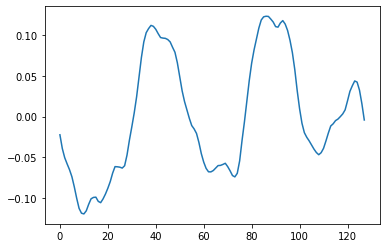

In [61]:
plt.plot(vis_x[0, 0, :, ic_dim])

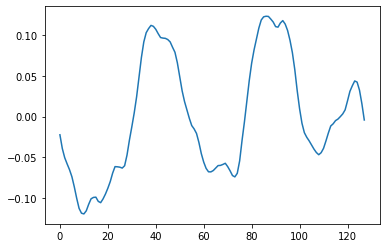

In [62]:
ic_truth, ic_pred, f_truth, f_pred = problem.physics_truth(vis_y, vis_x)
plt.plot(ic_truth[0])

In [63]:
def update_loss_dict(total, cur): 
    cur["loss"] = cur["loss"].item()
    if not total: 
        
        cur['batches'] = 1
        return cur
    
    for key, val in cur.items(): 
        total[key] += val
    total['batches'] += 1
    return total

def loss_metrics(total): 
    batches = total['batches']
    for key, val in total.items(): 
        total[key] = val/batches
    del total['batches']
    return total

def dict_to_str(dict): 
    str = ""
    for key, value in dict.items(): 
        if '_' in key: 
            continue
        str += f"{key}: {value:.5f} "
    return str


In [64]:
model.train()
epochs = 1
pbar = tqdm(range(epochs), dynamic_ncols=True, smoothing=0.1)
for ep in pbar: 
    total_loss = {}
    for x, y in train_loader: 
        x, y = x, y        
        output = model.predict(x) 
        cur_loss = loss(x, y, output)
        model.step(cur_loss)
        total_loss = update_loss_dict(total_loss, cur_loss)
    ic_pred = output["output"][0, 0, :, 0]
    plt.plot(x[0, 0, :, 0] - ic_pred.detach().numpy())
    break
    model.schedule_step()
    total_loss = loss_metrics(total_loss)
    pbar.set_description(dict_to_str(total_loss))


  0%|          | 0/1 [10:27<?, ?it/s]


KeyboardInterrupt: 